In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [98]:
weather = pd.read_csv('daily_weather.csv', index_col=0)
common = pd.read_csv('common_data.csv')
extended_yields = pd.read_csv('annual_yields.csv')

/Users/antheacheung/anaconda/envs/insight/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Preliminary Exploration

We begin our data exploration with a sample of the county yields compared to the national average for a handful of counties. As we can see, county-level yields that appear particularly high or low may match the national average. On the other hand, yields that seem non-anomalous on a county-level may actually diverge from the national average.

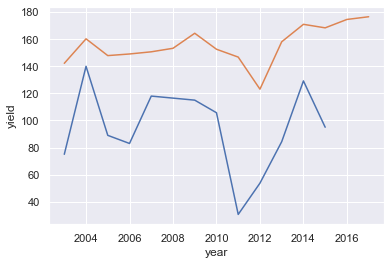

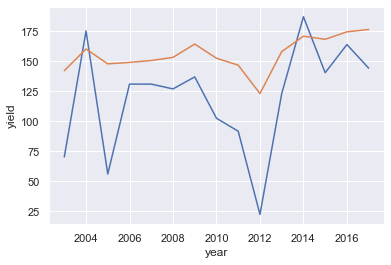

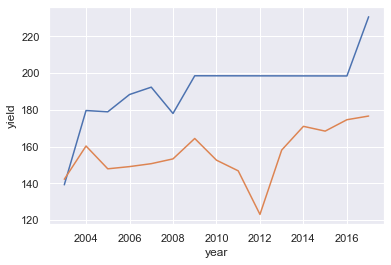

In [287]:
codes = common['adm2_code']
N = len(codes)
inds = np.random.randint(N,size=3)
samples = codes[inds].values

for s in samples:
    plt.figure()
    county = common[common['adm2_code']==s]
    sns.lineplot(county['year'],county['yield'])
    sns.lineplot(yields['year'],yields['yield'])
    plt.show()

In [ ]:
yields = extended_yields[extended_yields['year']>=2003]

The annual yields file contains national yields for years 1990-2017. There is quite a lot of variation from year to year. Since we only have data for 28 years, we approximate the increase in yields with a linear trend.

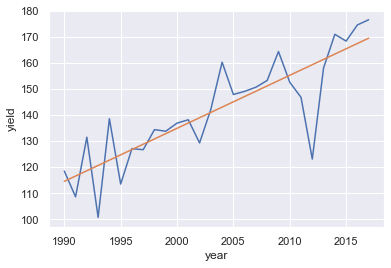

In [106]:
from sklearn.linear_model import LinearRegression
sns.set()
yields = extended_yields[extended_yields['year']>=2003]

clf = LinearRegression()
clf.fit(np.array(extended_yields['year']).reshape(-1, 1), extended_yields['yield'])
pred_yields = clf.predict(np.array(extended_yields['year']).reshape(-1,1))
sns.lineplot(extended_yields['year'],extended_yields['yield'])
sns.lineplot(extended_yields['year'],pred_yields)

## Approach

Since we are interested in identifying historical anomalies in yield and tying them to anomalies in weather data, our approach is to first identify anomalies using yield data. Once the anomalies are identified, we use those as labels for our data and use supervised learning to find weather features. To keep things simple, we start with a binary classification formulation, where yields are labeled as either anomalous or not anomalous.

As we can see from the above graph, there are also a few anomalous years in the national trend. For example, 2012 has noticeably lower yields nationally than nearby years. How we define anomalies in the yield data is central to our task. There are a few different ways to do so: for example, one way would be to look at each county independently and identify anomalies by looking at their annual yields in isolation. 

Another way would be to look at the difference in yields between each county and the national average, and identify anomalies in the *difference*. In the second approach, only counties that were particularly robust or particularly susceptible to the conditions that led to low yields nationally in 2012 would be identified as anomalies. 

As a first model, we chose an intermediate approach of comparing the county-level yields each year to the linear trend fitted above. This way, we expect most counties to be tagged as anomalous during years with particularly low or high yields. 

In [107]:
extended_yields = extended_yields.join(pd.Series(pred_yields,name='lin'))
common = pd.merge(common, extended_yields[['year','lin']], on = 'year')
common['lin_diff'] = common['yield'] - common['lin']
common.head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,lin,lin_diff
0,US01031,US01,2003,123.0,5500.0,72,295,141.014067,-18.014067
1,US01033,US01,2003,161.0,7800.0,84,281,141.014067,19.985933
2,US01049,US01,2003,100.0,12000.0,73,299,141.014067,-41.014067
3,US01071,US01,2003,121.0,21000.0,77,292,141.014067,-20.014067
4,US01077,US01,2003,145.0,8600.0,78,284,141.014067,3.985933


To identify anomalies, we therefore compute the difference between the county-level yield and the linear trend, and then find the mean and standard deviation of those differences grouped by county. Anomalies are then identified as differences that are more than two standard deviations away from the mean difference across years.

In [108]:
groups = common.groupby('adm2_code')
agg = pd.merge(groups['lin_diff'].mean(), groups['lin_diff'].std(), on='adm2_code')
agg.columns = ['mean', 'std']
agg.head()

,mean,std
adm2_code,,
US01031,-54.165511,25.934675
US01033,-14.286582,32.102637
US01049,-41.453799,28.369849
US01071,-41.647132,26.212269
US01077,-27.967132,30.632888


In [109]:
common = pd.merge(common, agg, on='adm2_code')
common.head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,lin,lin_diff,mean,std
0,US01031,US01,2003,123.0,5500.0,72,295,141.014067,-18.014067,-54.165511,25.934675
1,US01031,US01,2004,111.0,6900.0,72,295,143.050219,-32.050219,-54.165511,25.934675
2,US01031,US01,2005,127.0,6000.0,72,295,145.086371,-18.086371,-54.165511,25.934675
3,US01031,US01,2006,85.0,5600.0,72,295,147.122523,-62.122523,-54.165511,25.934675
4,US01031,US01,2007,73.0,8300.0,72,295,149.158675,-76.158675,-54.165511,25.934675


In [110]:
common['anomaly'] = (common['lin_diff'] > common['mean'] + 2*common['std'])|(common['lin_diff']<common['mean'] -2*common['std'])
common.head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,lin,lin_diff,mean,std,anomaly
0,US01031,US01,2003,123.0,5500.0,72,295,141.014067,-18.014067,-54.165511,25.934675,False
1,US01031,US01,2004,111.0,6900.0,72,295,143.050219,-32.050219,-54.165511,25.934675,False
2,US01031,US01,2005,127.0,6000.0,72,295,145.086371,-18.086371,-54.165511,25.934675,False
3,US01031,US01,2006,85.0,5600.0,72,295,147.122523,-62.122523,-54.165511,25.934675,False
4,US01031,US01,2007,73.0,8300.0,72,295,149.158675,-76.158675,-54.165511,25.934675,False


Here is a sample of different counties compared to the national average. Anomalous points are those that go below or above the thresholds given by the confidence intervals in the right-hand plots.

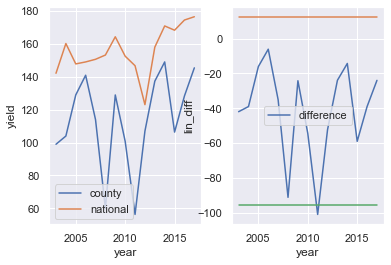

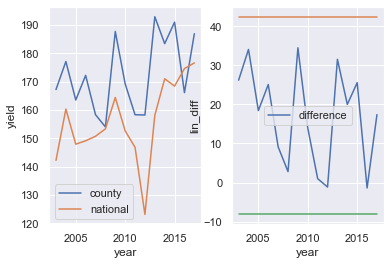

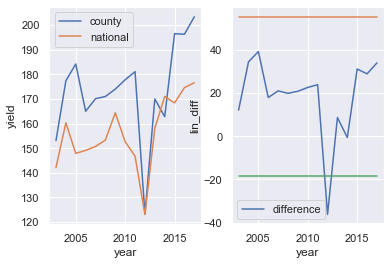

In [295]:
codes = common['adm2_code']
N = len(codes)
inds = np.random.randint(N,size=3)
samples = codes[inds].values

for sample in samples:
    plt.figure()
    county = common[common['adm2_code']==sample]
    plt.subplot(1, 2, 1)
    sns.lineplot(county['year'], county['yield'], label='county')
    sns.lineplot(yields['year'], yields['yield'], label='national')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.lineplot(county['year'],county['lin_diff'], label='difference')
    sns.lineplot(county['year'], county['mean'] + 2*county['std'])
    sns.lineplot(county['year'], county['mean'] - 2*county['std'])
    plt.legend()
    plt.show()

As a sanity check, we look at the distribution of years in the data points marked as anomalous and non-anomalous. The years 2004 and 2012 are over-represented in the anomalous class, which is what we expected from the linear trend.

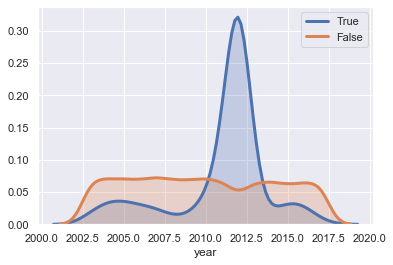

In [77]:
density(common_weather, 'year')

## Feature Engineering

Each county also has an estimated greenup and dormancy date. We use this information to group daily weather data into greenup and dormant periods, and take the mean of each weather metric. This is then merged into a weather_agg dataframe.

In [99]:
# extract greenup and dormancy dates
phen = pd.merge(common.groupby('adm2_code')['phen_gup'].mean(), common.groupby('adm2_code')['phen_dor'].mean(), on = 'adm2_code')

# group by greenup and dormant periods, then take the average
weather = pd.merge(weather, phen, on='adm2_code')
weather['gup_dor'] = (weather['doy']>= weather['phen_gup']) & (weather['doy']< weather['phen_dor'])
means= weather.groupby(['adm2_code','year', 'gup_dor']).mean()

dor = means.query('gup_dor == False')
gup = means.query('gup_dor == True')

# merge metrics into an aggregate dataframe
weather_agg = pd.merge(dor, gup, on=['adm2_code','year'],suffixes=('_dor','_gup') )

In [103]:
# drop extraneous columns
weather_agg = weather_agg.drop(['doy_dor', 'phen_gup_dor', 'phen_dor_dor', 'doy_gup', 'phen_gup_gup', 'phen_dor_gup'], 1)
weather_agg.columns

Index(['met_avg_t_dor', 'met_gdd_dor', 'met_max_rh_dor', 'met_max_t_dor',
       'met_max_vpd_dor', 'met_min_rh_dor', 'met_min_t_dor', 'met_p_mm_dor',
       'met_sh_dor', 'met_sr_wm2_dor', 'met_avg_t_gup', 'met_gdd_gup',
       'met_max_rh_gup', 'met_max_t_gup', 'met_max_vpd_gup', 'met_min_rh_gup',
       'met_min_t_gup', 'met_p_mm_gup', 'met_sh_gup', 'met_sr_wm2_gup'],
      dtype='object')

In [112]:
# merge labels to weather_agg dataframe
weather_agg = pd.merge(weather_agg, common[['anomaly','adm2_code', 'year']], on=['adm2_code', 'year'])

In [193]:
features=weather_agg.columns[2:-1]

In [ ]:
def density_phen(df, feat):
    plt.figure()
    plt.subplot(1, 2, 1)
    for l in [True, False]:
        subset = df[df['anomaly'] == l]
        sns.distplot(subset[feat+'_gup'], hist=False,kde = True,
                 kde_kws = {'linewidth': 3,'shade':True},
                 label = l)
    plt.subplot(1, 2, 2)
    for l in [True, False]:
        subset = df[df['anomaly'] == l]
        sns.distplot(subset[feat+'_dor'], hist=False,kde = True,
                 kde_kws = {'linewidth': 3,'shade':True},
                 label = l)
    plt.show()

## Feature data exploration 

Now let's compare the distribution of each feature in the anomalous and non-anomalous classes. We can see that for the most part, there is a fair amount of overlap in each of the metrics, but the distributions are different. Moreover, certain features such as the relative humidity and vapor pressure deficit are much more informative in the greenup period. On the other hand, the average minimum temperature during the dormancy period seems more informative than in the greenup period.

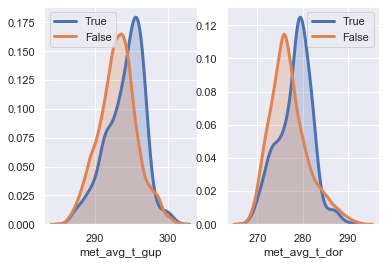

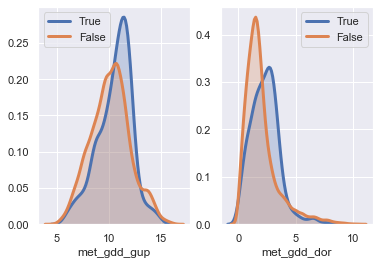

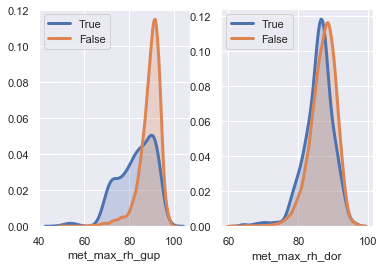

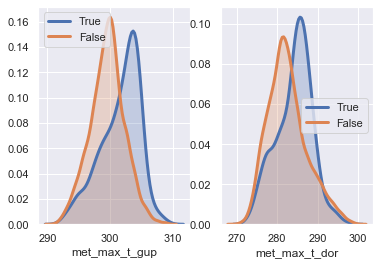

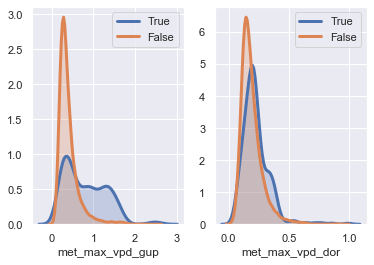

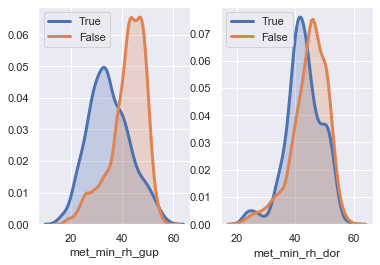

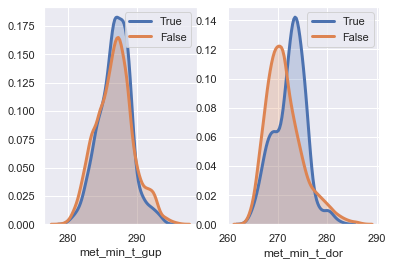

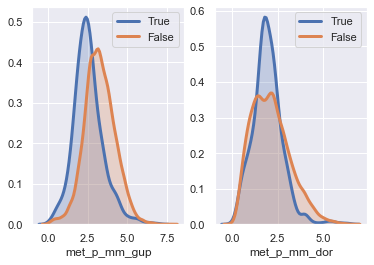

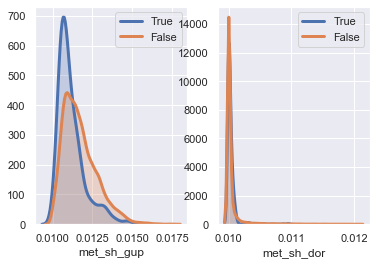

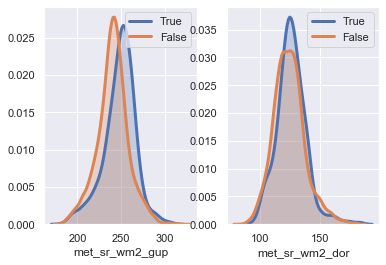

In [234]:
feat_base = ['met_avg_t', 'met_gdd', 'met_max_rh',
       'met_max_t', 'met_max_vpd', 'met_min_rh', 'met_min_t', 'met_p_mm',
       'met_sh', 'met_sr_wm2']
for feat in feat_base:
    density_phen(weather_agg, feat)

Additional feature engineering would be an interesting avenue to explore. For example, since extreme weather conditions may have a large effect on crops, taking specific percentiles as opposed to means of different metrics may be useful. For now, we proceed with the greenup and dormant averages.

## Splitting into training and testing data

There are two major dependencies in our data: by county and by year. The appropriate splitting of our data into train and test sets will depend on the most important task at hand: for example, if we want to be able to generalize well to unseen counties, then leaving out entire counties would be more important. On the other hand if we wanted to be able to generalize to future years, then leaving out subsets of years would be more important. The most stringent method would be to leave out a subset of counties *and* a subset of years. We chose the approach of leaving out subsets of counties, to be able to generalize to unseen counties. 

In [207]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

for tr,te in gkf.split(weather_agg, groups=weather_agg['adm2_code']):
    print(train,test)
train = weather_agg.iloc[tr]
test = weather_agg.iloc[te]
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features])
scaled_test = scaler.transform(test[features])
y_train = train['anomaly']
y_test= test['anomaly']

[    0     1     2 ... 14274 14275 14276] [   24    25    26 ... 14233 14234 14235]
[    0     1     2 ... 14274 14275 14276] [   24    25    26 ... 14233 14234 14235]
[    0     1     2 ... 14274 14275 14276] [   24    25    26 ... 14233 14234 14235]
[    0     1     2 ... 14274 14275 14276] [   24    25    26 ... 14233 14234 14235]
[    0     1     2 ... 14274 14275 14276] [   24    25    26 ... 14233 14234 14235]


## Baseline models

We try two baseline models: logistic regression and random forest with no tuning. Since we expect the features to be dependent and have non-linear relationships with the target variable, the logistic regression model is expected to perform poorly.

In [247]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga').fit(scaled_train, y_train)
y_pred = clf.predict(scaler.transform(test[features]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.88      0.93      3401
        True       0.22      0.66      0.33       164

    accuracy                           0.87      3565
   macro avg       0.60      0.77      0.63      3565
weighted avg       0.95      0.87      0.90      3565



/Users/antheacheung/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [239]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
clf.fit(scaled_train, y_train)  
y_pred = clf.predict(scaled_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      3401
        True       0.67      0.55      0.61       164

    accuracy                           0.97      3565
   macro avg       0.82      0.77      0.79      3565
weighted avg       0.96      0.97      0.97      3565



## Cross-validation

To tune our model, we perform grid search cross-validation by holding out different counties. For this problem, we care most about recalling the anomalous data points (i.e, we want to identify as many possible weather anomalies that are linked to yield anomalies). Since our data is imbalanced, we therefore use the macro recall as our socring function.

In [243]:
from sklearn.model_selection import GridSearchCV
gkf = GroupKFold(n_splits=5)
splitter = gkf.split(train, groups=train['adm2_code'])
rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
params = {'max_depth':[None, 5, 10], 'min_samples_split':[2, 5, 10]}
grid = GridSearchCV(rf, param_grid=params, cv = splitter,verbose=2, n_jobs=-1, scoring='recall_macro')

In [244]:
grid.fit(scaled_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  9.9min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x125a85570>,
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False,
                                             

In [245]:
best = grid.best_estimator_
best.fit(scaled_train, y_train)  
y_pred = best.predict(scaled_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.95      0.97      3401
        True       0.40      0.62      0.48       164

    accuracy                           0.94      3565
   macro avg       0.69      0.79      0.73      3565
weighted avg       0.95      0.94      0.95      3565



## Results

After cross-validation, our best model is a random forest classifier with a maximum depth of 5. Sorting the predictors by feature importance shows that anomalous minimum relative humidity, maximum vapor pressure deficit, and precipitation during the greenup period are the most important features. In general, weather metrics between the greenup and dormancy dates are more important.

In [246]:
print(best)
print(best.feature_importances_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
[0.0448429  0.01874915 0.01793411 0.02926563 0.02713091 0.03775551
 0.05642027 0.03321809 0.01521496 0.01966167 0.01655082 0.01553367
 0.08503224 0.06925422 0.15027477 0.17258251 0.02567103 0.08632357
 0.05091614 0.02766782]


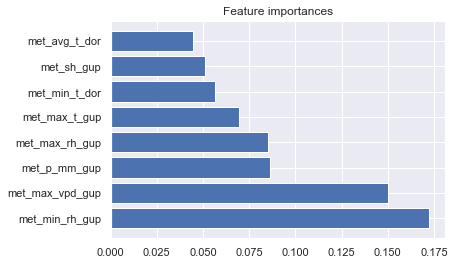

In [286]:
importances = best.feature_importances_
indices = np.argsort(-1*importances)[:8]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(8), importances[indices],
        align="center")
plt.yticks(range(8), features[indices])
plt.show()

## Possible next steps

We have just scratched the surface on possible solutions to this problem. Here are some major considerations for next steps:

1) Explore additional feature engineering, such as 25th and 75th percentiles of metrics.

2) Creating aggregate state-level features, and historical features (for example, weather or yield from previous years).

3) Evaluating our models with more stringent cross-validation, by holding out subsets of counties and years.

4) Experimenting with oversampling and undersampling methods in models.

5) Casting the problem into a ternary classification problem (anomalous-low, normal, anomalous-high) or a regression problem (predict the difference between the county-level yield and the national linear trend). 